In [48]:
!pip install lightgbm

Необходимо установить следующие бибилиотеки

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error

Загрузка таблицы

In [9]:
covid_df = pd.read_csv('Table_2020-12-05_22-35.csv', sep = ';')
covid_df.head(5)

,Дата,Регион,Заражений,Выздоровлений,Смертей,Смертей за день,Заражений за день,Выздоровлений за день
0,12.03.2020,Адыгея,0,0,0,0,0,0
1,12.03.2020,Алтайский край,0,0,0,0,0,0
2,12.03.2020,Амурская обл.,0,0,0,0,0,0
3,12.03.2020,Архангельская обл.,0,0,0,0,0,0
4,12.03.2020,Астраханская обл.,0,0,0,0,0,0


Для беспрепятственного использования среды Python, наименования столбцов были переименованы в свои аналоги на английском языке.

In [10]:
covid_df = covid_df.rename(columns = {'Дата': 'Date', 'Регион': 'Region', 'Заражений': 'Infected', 'Выздоровлений': 'Recovered',
                                     'Смертей': 'Deaths', 'Смертей за день': 'Deaths per day', 
                                      'Заражений за день': 'Infected per day', 'Выздоровлений за день': 'Recovered per day'}, inplace = False)

Извлекается информация по рассматриваемому региону "Москва"

In [11]:
covid_df = covid_df[covid_df.Region.str.contains('Москва',case=False)]
covid_df.head(5)

,Date,Region,Infected,Recovered,Deaths,Deaths per day,Infected per day,Recovered per day
40,12.03.2020,Москва,21,0,0,0,21,0
122,13.03.2020,Москва,26,0,0,0,5,0
204,14.03.2020,Москва,35,0,0,0,9,0
286,15.03.2020,Москва,35,1,0,0,0,1
368,16.03.2020,Москва,53,1,0,0,18,0


In [7]:
covid_df['Date'] = pd.to_datetime(covid_df['Date'])
covid_df.set_index('Date', inplace=True)

Описание используемых данных

In [5]:
covid_df.describe()

,Infected,Recovered,Deaths,Deaths per day,Infected per day,Recovered per day
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,236628.739777,167671.260223,3861.758364,34.486989,2379.368030,1804.118959
std,157392.324253,127801.385582,2540.632648,25.723066,2160.568992,1718.005026
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,146062.000000,28913.000000,1580.000000,12.000000,680.000000,632.000000
50%,236616.000000,173854.000000,4375.000000,28.000000,1359.000000,1235.000000
75%,290293.000000,247301.000000,5203.000000,58.000000,4174.000000,2427.000000
max,640050.000000,485308.000000,9277.000000,78.000000,7993.000000,8033.000000


Построение графиков динамики случаев заражения и летальных исходов.

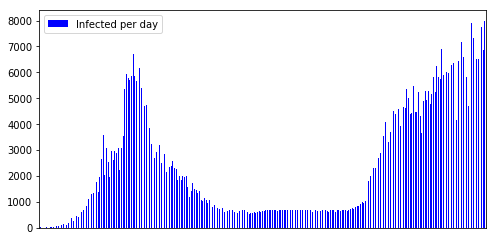

In [43]:
plt.rcParams["figure.figsize"]=8,4  
# Plot column 'Confirmed'
covid_df.plot(kind = 'bar', x = 'Date', y = 'Infected per day', color = 'blue')

ax1 = plt.gca()
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()
plt.close()

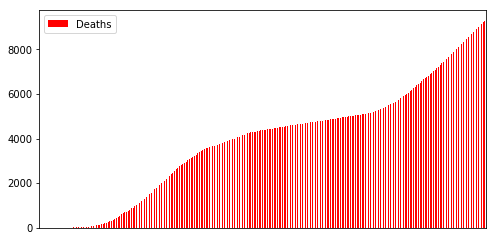

In [41]:
plt.rcParams["figure.figsize"]=8,4  
ax1 = plt.gca()
covid_df.plot(kind = 'bar', x = 'Date', y = 'Deaths', color = 'red', ax = ax1)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()
plt.close()

In [28]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [29]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [30]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.
    
    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

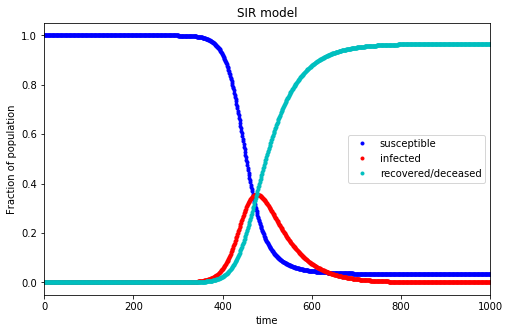

In [31]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.show()

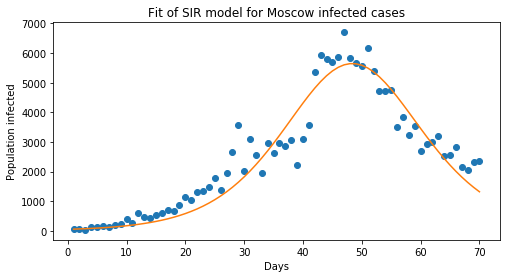

Optimal parameters: beta = 4.295130523461259  and gamma =  4.1681688124339376


In [58]:
population = float(12678079)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = covid_df.loc[covid_df['Region']=='Москва'].Infected.diff().fillna(0)
country_df = country_df[10:80]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Moscow infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [59]:
mean_squared_log_error(ydata, fitted)

0.14424905121676135